In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
#download pip install xlrd
from sklearn.preprocessing import StandardScaler


In [7]:
file_path = "default of credit card clients.xls"
df = pd.read_excel(file_path, skiprows=1)

In [8]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [9]:
#Remove NaN values - Drop rows with any NaN values
df = df.dropna()

In [10]:
#fill NaN values based on data type or specific columns
for column in df.columns:
    if df[column].dtype == "object":  # If it's a categorical column
        df[column].fillna(df[column].mode()[0], inplace=True)
    else:  # For numerical columns
        df[column].fillna(df[column].median(), inplace=True)

<ipython-input-10-50373002e4a9>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].median(), inplace=True)


In [11]:
#Remove duplicate rows
df = df.drop_duplicates()

In [12]:
#Standardize column names (lowercase and replace spaces with underscores for consistency)
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [13]:
print(df.columns)
# Strip any leading/trailing whitespace from column names
df.columns = df.columns.str.strip()

Index(['id', 'limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_0',
       'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
       'default_payment_next_month'],
      dtype='object')


In [14]:
# Remove rows where all bill and payment amounts are zero
bill_cols = ['bill_amt1', 'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6']
pay_cols = ['pay_amt1', 'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']

df = df[~((df[bill_cols].sum(axis=1) == 0) & (df[pay_cols].sum(axis=1) == 0))]

In [15]:
# Handle outliers in 'LIMIT_BAL', BILL_AMT*, and PAY_AMT*
q_low = df["limit_bal"].quantile(0.01)
q_high = df["limit_bal"].quantile(0.99)
df = df[(df["limit_bal"] >= q_low) & (df["limit_bal"] <= q_high)]

for column in bill_cols:
    q_low = df[column].quantile(0.01)
    q_high = df[column].quantile(0.99)
    df = df[(df[column] >= q_low) & (df[column] <= q_high)]

for column in pay_cols:
    q_low = df[column].quantile(0.01)
    q_high = df[column].quantile(0.99)
    df = df[(df[column] >= q_low) & (df[column] <= q_high)]

In [16]:
df['sex'] = df['sex'].astype('category')
df['education'] = df['education'].astype('category')
df['marriage'] = df['marriage'].astype('category')

In [17]:
##FEATURING ENGINEERING?? - NOT SURE IF THIS IS RIGHT
df = pd.get_dummies(df, columns=['sex', 'education', 'marriage'], drop_first=True)
df = df.drop(columns=['id'])


In [18]:
# Identify numerical columns for scaling
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Initialize scaler
scaler = StandardScaler()

# Apply scaling
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

#NOT SURE IF THIS IS RIGHT LOL
X = 0 # Explanatory variables
y = 0 # response variable

In [19]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 24223 entries, 0 to 29999
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_bal                   24223 non-null  float64
 1   age                         24223 non-null  float64
 2   pay_0                       24223 non-null  float64
 3   pay_2                       24223 non-null  float64
 4   pay_3                       24223 non-null  float64
 5   pay_4                       24223 non-null  float64
 6   pay_5                       24223 non-null  float64
 7   pay_6                       24223 non-null  float64
 8   bill_amt1                   24223 non-null  float64
 9   bill_amt2                   24223 non-null  float64
 10  bill_amt3                   24223 non-null  float64
 11  bill_amt4                   24223 non-null  float64
 12  bill_amt5                   24223 non-null  float64
 13  bill_amt6                   24223 no

In [29]:
X = df.drop(columns=['default_payment_next_month'])
y = df['default_payment_next_month']
y = y.astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

#Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy)
print("ROC-AUC Score:", roc_auc)

class_report_display = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report_display)

Accuracy: 0.8143663134718591
ROC-AUC Score: 0.7341878396010679
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      5663
           1       0.69      0.29      0.41      1604

    accuracy                           0.81      7267
   macro avg       0.76      0.63      0.65      7267
weighted avg       0.80      0.81      0.78      7267



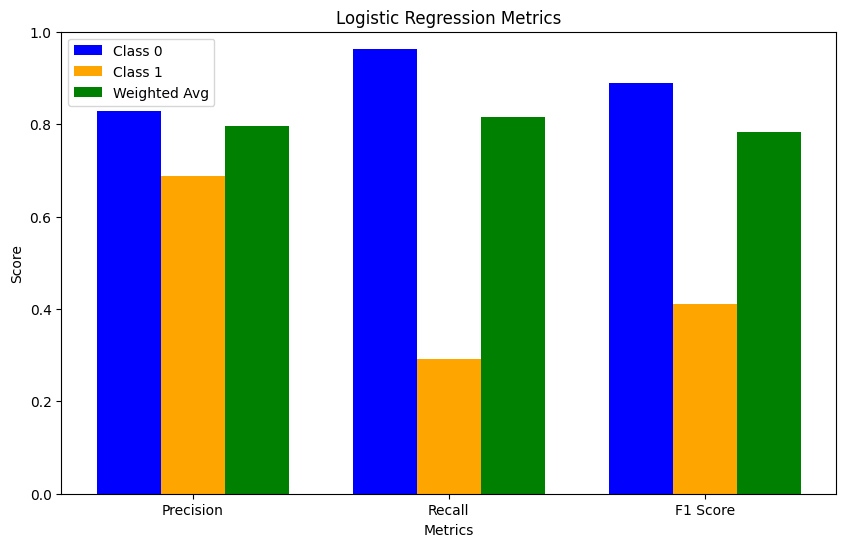

In [35]:
#Classification Report Visualization
report = classification_report(y_test, y_pred, output_dict=True)
precision_0 = report['0']['precision']
recall_0 = report['0']['recall']
f1_0 = report['0']['f1-score']

precision_1 = report['1']['precision']
recall_1 = report['1']['recall']
f1_1 = report['1']['f1-score']

precision_weighted = report['weighted avg']['precision']
recall_weighted = report['weighted avg']['recall']
f1_weighted = report['weighted avg']['f1-score']

# Metrics and values for the grouped bar chart
metrics = ['Precision', 'Recall', 'F1 Score']
values_0 = [precision_0, recall_0, f1_0]
values_1 = [precision_1, recall_1, f1_1]
values_weighted = [precision_weighted, recall_weighted, f1_weighted]

# Create the grouped bar chart
x = np.arange(len(metrics))  # the label locations
width = 0.25  # bar width

plt.figure(figsize=(10, 6))
plt.bar(x - width, values_0, width, label='Class 0', color='blue')
plt.bar(x, values_1, width, label='Class 1', color='orange')
plt.bar(x + width, values_weighted, width, label='Weighted Avg', color='green')

plt.ylabel('Score')
plt.title('Logistic Regression Metrics')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.legend(loc='upper left')

plt.show()


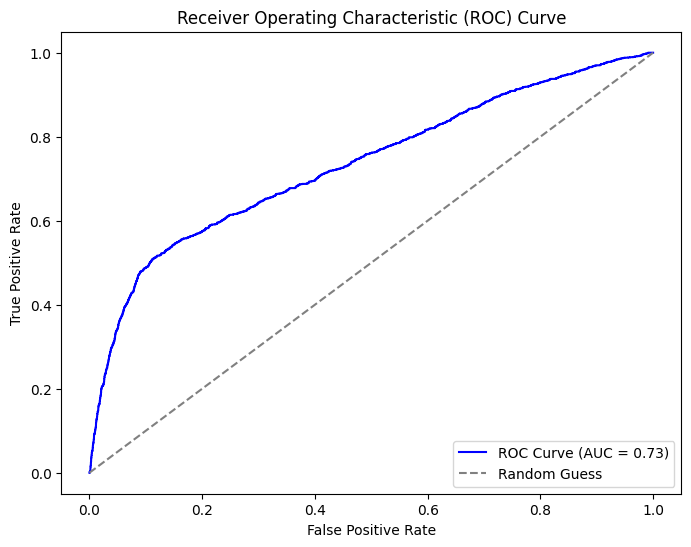

In [22]:
#ROC Curve Visualization
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()